In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np
from argparse import ArgumentParser, RawDescriptionHelpFormatter
import yaml

%matplotlib inline
import matplotlib.pyplot as plt

**Exercise 1**

**In the first exercise, run the model 3 times using the same initial thermodynamic conditions 
as in the example code. Run the model over a 500 m depth, and run with an updraft speed 
of 1, 5, and 10 m s-1 (these are analogous to stratiform, weak convective, and moderately 
convective clouds).**


1. How does varying the updraft speed impact the maximum supersaturation? Why is this?

`Answer: The maximum supersaturation increases with increasing updraft speed (from 1m/s : 0.62 to 5 m/s : 1.26 to 10 m/s : 1.75) . When air rises due to an updraft, it cools and expands adiabatically (without any exchange of heat with its surroundings). The cooling rate is dependent on the speed of the updraft. A faster updraft (increasing updraft speed) will result in a higher cooling rate, causing more water vapor to condense into cloud droplets. This means that a faster updraft can lead to a higher level of supersaturation but only to the point before cloud droplets begin to fall out of the cloud. If the updraft speed is too low, there may not be enough upward motion to lift the air to a level where it can cool and condense, resulting in a lower maximum supersaturation. On the other hand, if the updraft speed is too high, the water droplets or ice crystals may be carried out of the environment before they have a chance to grow and precipitate, also resulting in a lower maximum supersaturation.`

2. How does the height of the level of maximum supersaturation change with changing updraft speed?

`Answer: The height of the level of maximum supersaturation rises or increases with increasing updraft speed (from approximately 70 m to about 100 m).`

3. Consider the number of aerosol activated as a function of updraft speed. This is simply the number of cloud droplets (ND). How does cloud droplet number concentration change with updraft speed and why?

`Answer: The cloud droplet number concentration increases (from 156.9 to 455.2 and finally to 607.1) indicating that the active fraction also increases with increasing updraft speed. In general, as the updraft speed increases, more aerosols can be activated, leading to an increase in cloud droplet number concentration. This occurs because stronger updrafts provide more vertical motion, which can lift more aerosols into the cloud-forming region and facilitate their activation into cloud droplets.
The relationship between updraft speed and cloud droplet number concentration is often described by the Köhler curve, which shows how the critical supersaturation required for aerosol activation varies with aerosol size and composition. As updraft speed increases, the critical supersaturation required for activation decreases, allowing more aerosols to become cloud droplets.
`

### For updraft speed = 1 m/s

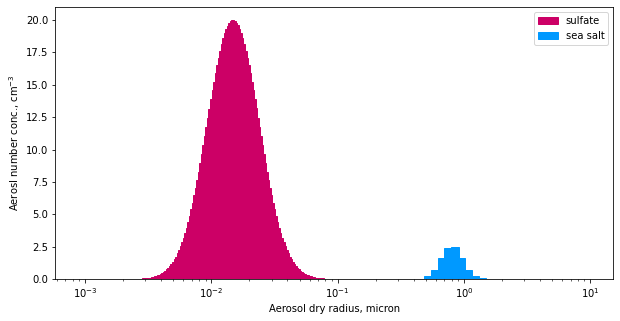

In [2]:
#set initial conditions

P0 = 77500. # Pressure, Pa
T0 = 274.   # Temperature, K
S0 = -0.02  # Supersaturation, 1-RH (98% here)

sulfate =  pm.AerosolSpecies('sulfate',
                             pm.Lognorm(mu=0.015, sigma=1.6, N=850.),
                             kappa=0.54, bins=200)
sea_salt = pm.AerosolSpecies('sea salt',
                             pm.Lognorm(mu=0.85, sigma=1.2, N=10.),
                             kappa=1.2, bins=40)
  

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")
sea_c = "#0099FF"
ax.bar(sea_salt.rs[:-1], sea_salt.Nis*1e-6, np.diff(sea_salt.rs),
        color=sea_c, label="sea salt", edgecolor="#0099FF")
ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate, sea_salt]
V = 1.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

In [3]:
#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

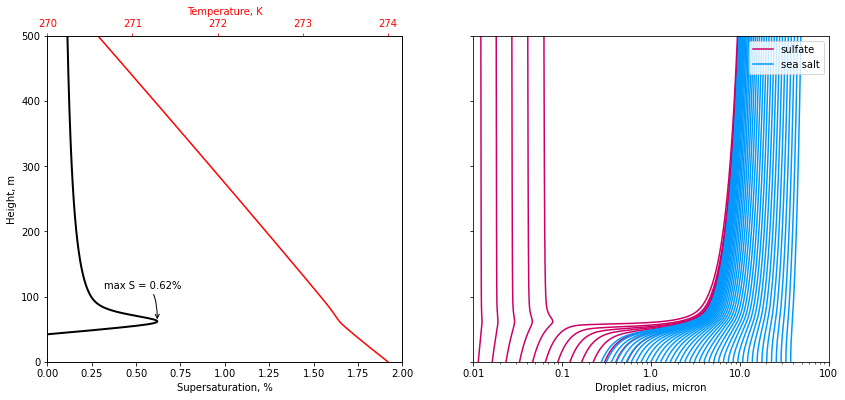

In [4]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate', 'sea salt'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [5]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']
sea_trace = aerosol_traces['sea salt']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

eq_sea, kn_sea, alpha_sea, phi_sea = \
    pm.binned_activation(Smax/100, T, sea_trace.iloc[ind_final], sea_salt)
eq_sea *= sea_salt.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print(" CDNC(sea salt) = {:3.1f}".format(eq_sea))
print("------------------------")
print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf+eq_sea,
      sea_salt.total_N+sulfate.total_N,
      (eq_sulf+eq_sea)/(sea_salt.total_N+sulfate.total_N)))



  CDNC(sulfate) = 146.9
 CDNC(sea salt) = 10.0
------------------------
          total = 156.9 / 860 ~ act frac = 0.18


### For Updraft speed = 5 m/s:

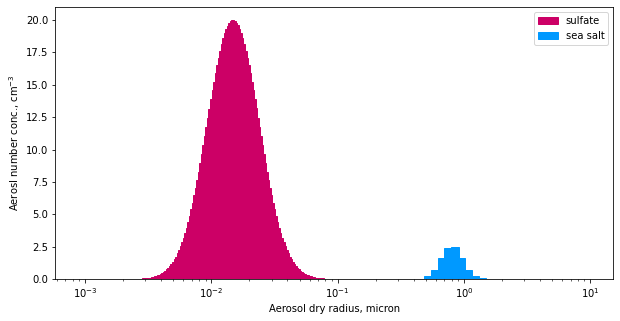

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")
sea_c = "#0099FF"
ax.bar(sea_salt.rs[:-1], sea_salt.Nis*1e-6, np.diff(sea_salt.rs),
        color=sea_c, label="sea salt", edgecolor="#0099FF")
ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate, sea_salt]
V = 5.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

In [7]:
#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

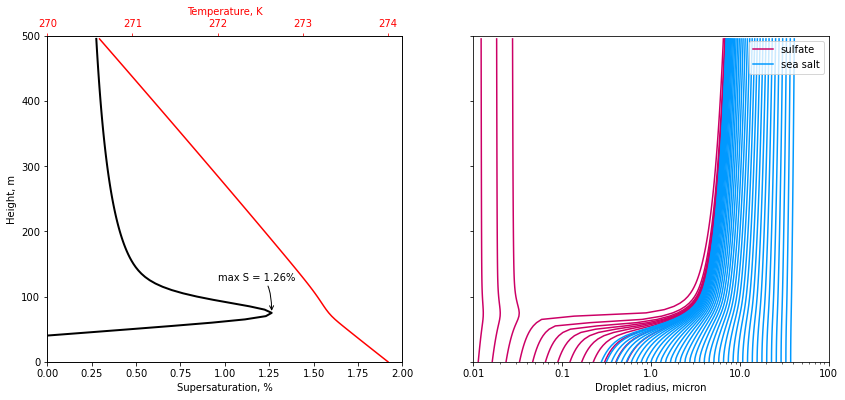

In [8]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate', 'sea salt'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [9]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']
sea_trace = aerosol_traces['sea salt']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

eq_sea, kn_sea, alpha_sea, phi_sea = \
    pm.binned_activation(Smax/100, T, sea_trace.iloc[ind_final], sea_salt)
eq_sea *= sea_salt.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print(" CDNC(sea salt) = {:3.1f}".format(eq_sea))
print("------------------------")
print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf+eq_sea,
      sea_salt.total_N+sulfate.total_N,
      (eq_sulf+eq_sea)/(sea_salt.total_N+sulfate.total_N)))



  CDNC(sulfate) = 445.2
 CDNC(sea salt) = 10.0
------------------------
          total = 455.2 / 860 ~ act frac = 0.53


### For updraft speed = 10 m/s:

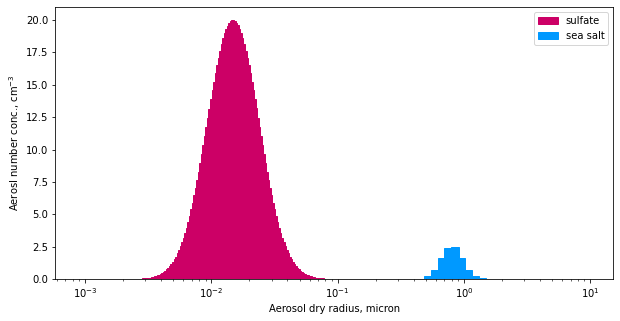

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")
sea_c = "#0099FF"
ax.bar(sea_salt.rs[:-1], sea_salt.Nis*1e-6, np.diff(sea_salt.rs),
        color=sea_c, label="sea salt", edgecolor="#0099FF")
ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate, sea_salt]
V = 10.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

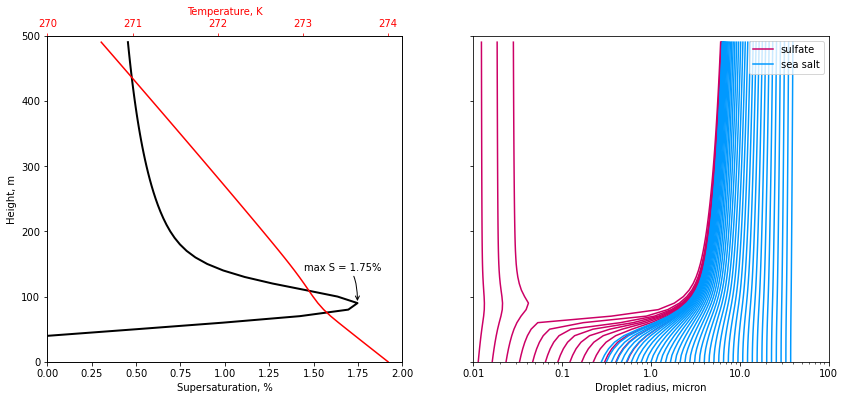

In [11]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate', 'sea salt'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [12]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']
sea_trace = aerosol_traces['sea salt']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

eq_sea, kn_sea, alpha_sea, phi_sea = \
    pm.binned_activation(Smax/100, T, sea_trace.iloc[ind_final], sea_salt)
eq_sea *= sea_salt.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print(" CDNC(sea salt) = {:3.1f}".format(eq_sea))
print("------------------------")
print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf+eq_sea,
      sea_salt.total_N+sulfate.total_N,
      (eq_sulf+eq_sea)/(sea_salt.total_N+sulfate.total_N)))



  CDNC(sulfate) = 597.1
 CDNC(sea salt) = 10.0
------------------------
          total = 607.1 / 860 ~ act frac = 0.71


**Exercise 2**

***Now let’s investigate impacts of the input aerosol. Run the model 2 times using the same 
initial thermodynamic conditions as in the example code. Run the model over a 500 m 
depth and with an updraft speed of 5 m s-1 (this is analogous to a weak convective cloud). 
For the first run, use the same aerosol as in the sample case. For the second initiate the 
model with only the sulfate aerosol.***

1. How do the maximum supersaturation and droplet concentration vary between the two runs? Explain these results.

`Answer: For the first run (initiated with both sulfate and sea salt), the maximum supersaturation was 1.26 % with droplet concentration of 445.2 for the sulfate aerosol and 10 for the sea salt totaling 455.2 indicating an active fraction of 0.53 whereas in the second run (initiated with only the sulfate aerosol), both the maximum supersaturation and droplet concentration were higher (1.31% and 465.1 respectively, indicating an active fraction of 0.55). 
The maximum supersaturation in a weak convective cloud can be lower when sea salt aerosols are present in addition to sulfate aerosols. This is because the presence of sea salt aerosols can act as a sink for water vapor (the hygroscopic property of sea salt), effectively reducing the amount of water vapor available for other aerosols (sulfate in this case) to activate into cloud droplets.
As a result, when both types of aerosols are present in a weak convective cloud, the sea salt aerosols can activate before the sulfate aerosols, effectively reducing the amount of water vapor available for the sulfate aerosols to activate and form cloud droplets. This effect can lead to a reduction in cloud droplet number concentration and a corresponding decrease in maximum supersaturation.
`

### For both sulfate and sea salt:

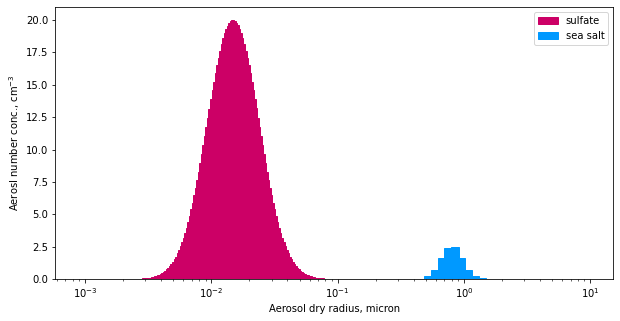

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")
sea_c = "#0099FF"
ax.bar(sea_salt.rs[:-1], sea_salt.Nis*1e-6, np.diff(sea_salt.rs),
        color=sea_c, label="sea salt", edgecolor="#0099FF")
ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate, sea_salt]
V = 5.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

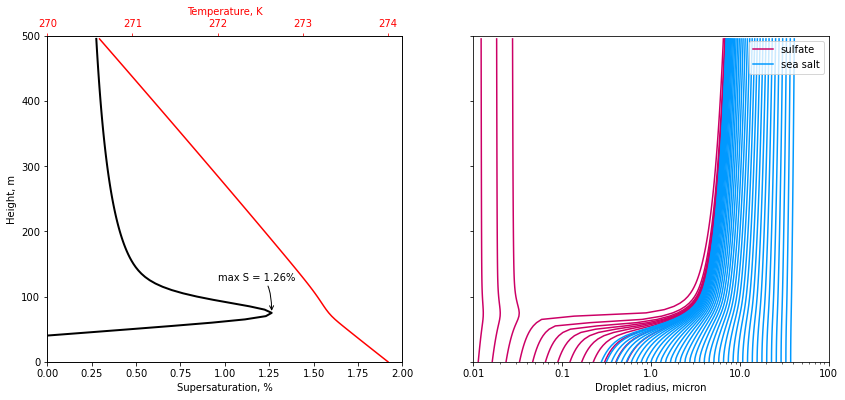

In [14]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate', 'sea salt'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [15]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']
sea_trace = aerosol_traces['sea salt']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

eq_sea, kn_sea, alpha_sea, phi_sea = \
    pm.binned_activation(Smax/100, T, sea_trace.iloc[ind_final], sea_salt)
eq_sea *= sea_salt.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print(" CDNC(sea salt) = {:3.1f}".format(eq_sea))
print("------------------------")
print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf+eq_sea,
      sea_salt.total_N+sulfate.total_N,
      (eq_sulf+eq_sea)/(sea_salt.total_N+sulfate.total_N)))


  CDNC(sulfate) = 445.2
 CDNC(sea salt) = 10.0
------------------------
          total = 455.2 / 860 ~ act frac = 0.53


### For sulfate aerosol only:

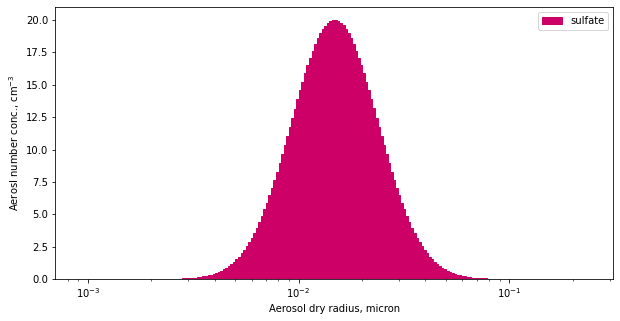

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")

ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate]
V = 5.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

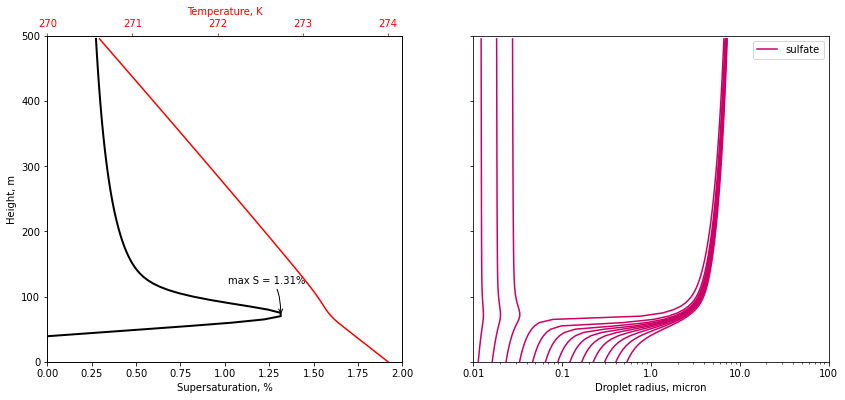

In [17]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
#sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
#sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [18]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print("------------------------")

print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf,
      sulfate.total_N,
      (eq_sulf)/(sulfate.total_N)))

  CDNC(sulfate) = 465.1
------------------------
          total = 465.1 / 850 ~ act frac = 0.55


**Exercise 3**

***Now we’ll consider variations in aerosol concentration. Two runs: same thermodynamic 
conditions; updraft of 5 m s-1, 500 m depth. Use sulfate aerosol at 850 cm-3 and 1700 cm-3.***

1. How does varying the aerosol concentration impact the maximum supersaturation and the droplet number concentration. Explain

`Answer: The maximum supersaturation is higher (1.31%) in the weak convective cloud with lower concentration of sulfate aerosol (850 cm-3) compared to that with higher concentration (1.14 % for 1700 cm-3 of sulfate aerosol). The droplet number concentration on the other hand is higher for the higher concentration of sulfate aerosol (770.6) as compared to that of the lower concentration of sulfate aerosol (465.1).
Increasing the concentration of sulfate aerosol can increase the number of cloud droplets formed, but it can also reduce the maximum supersaturation in a cloud. When there are more sulfate aerosol particles available, more of them can act as cloud condensation nuclei (CCN) for water vapor to condense and form cloud droplets. This leads to an increase in the cloud droplet number concentration, as there are more droplets formed for the same amount of water vapor available.
However, as the concentration of sulfate aerosol increases, the competition for water vapor among the aerosols also increases. This means that each individual aerosol may have less water vapor available to activate and form a cloud droplet, leading to a higher critical supersaturation threshold for activation. In other words, it takes a higher level of supersaturation to activate the same number of aerosols when the concentration is higher. As a result, at higher concentrations of sulfate aerosol, the maximum supersaturation is reduced, since a higher level of supersaturation is required to activate the same number of aerosols. This reduction in maximum supersaturation can in turn reduce the number of aerosols that can activate into cloud droplets, leading to a decrease in the cloud droplet number concentration. However, the increase in the number of aerosols available to act as CCN typically outweighs the reduction in maximum supersaturation, resulting in an overall increase in the cloud droplet number concentration.
`

### For sulfate concentration of 850 cm-3:

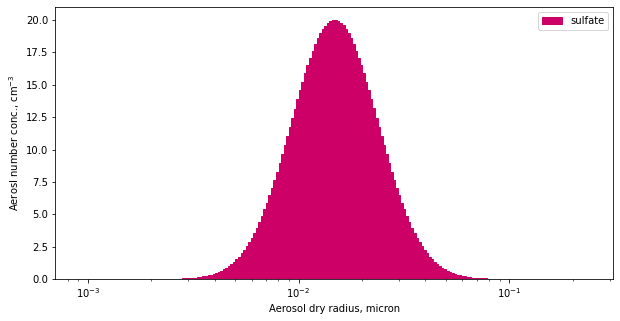

In [19]:
sulfate =  pm.AerosolSpecies('sulfate',
                             pm.Lognorm(mu=0.015, sigma=1.6, N=850.),
                             kappa=0.54, bins=200)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")

ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate]
V = 5.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

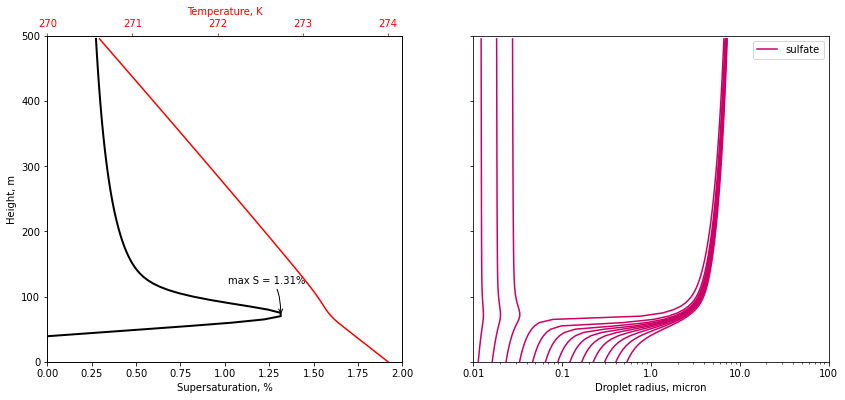

In [20]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
#sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
#sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [21]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print("------------------------")

print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf,
      sulfate.total_N,
      (eq_sulf)/(sulfate.total_N)))

  CDNC(sulfate) = 465.1
------------------------
          total = 465.1 / 850 ~ act frac = 0.55


### For sulfate concentration of 1700 cm-3:

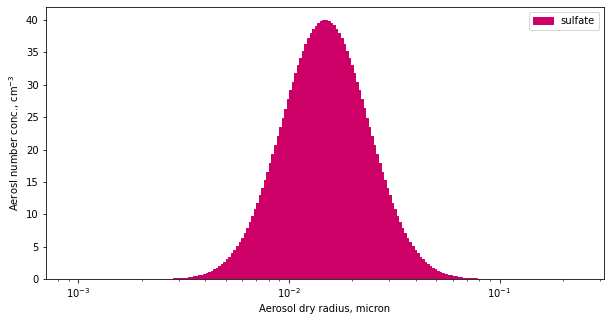

In [22]:
sulfate =  pm.AerosolSpecies('sulfate',
                             pm.Lognorm(mu=0.015, sigma=1.6, N=1700.),
                             kappa=0.54, bins=200)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")

ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

initial_aerosols = [sulfate]
V = 5.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 500./V # end time, seconds... 500 meter simulation

#run the parcel meeting
model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

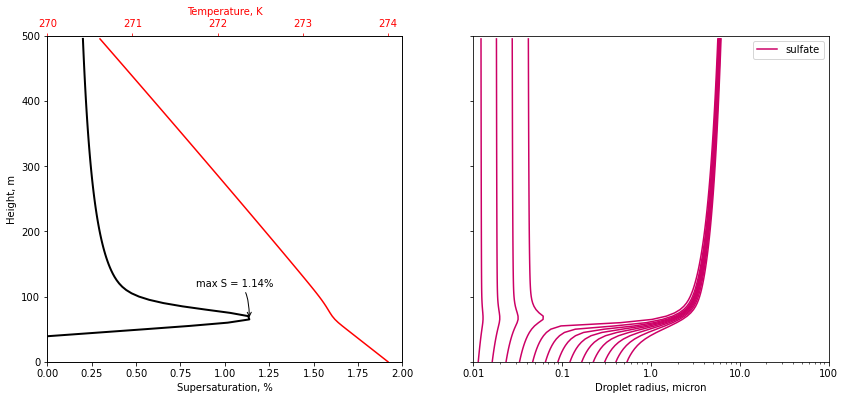

In [23]:
#build figures 
fig, [axS, axA] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].iloc[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax,
             xy=(Smax, z_at_smax),
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 2)
axS.set_ylim(0, 500)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
#sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c,
         label="sulfate")
#sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 100.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1,1e2], [0.01, 0.1, 1.0, 10.0,100])
axA.legend([ss[0], sa[0]], ['sulfate'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In [24]:
#output results for activated aerosol
sulf_trace = aerosol_traces['sulfate']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    pm.binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N


print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print("------------------------")

print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf,
      sulfate.total_N,
      (eq_sulf)/(sulfate.total_N)))

  CDNC(sulfate) = 770.6
------------------------
          total = 770.6 / 1700 ~ act frac = 0.45
